In [2]:
df = spark.read.format('com.databricks.spark.csv').\
                               options(header='true', \
                               inferschema='true') \
                .load("/home/bigdata/unswnb15_old.csv",header=True);
#df.show(5,True)

In [3]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['dur',
                                               'sbytes',
                                               'dbytes',
                                               'sttl',
                                               'dttl',
                                               'sloss',
                                               'dloss',
                                               'sload',
                                               'dload',
                                               'spkts',
                                               'tcprtt',
                                               'synack',
                                               'is_sm_ips_ports',
                                               'dpkts',
                                               'ct_dst_sport_ltm',
                                               'ct_dst_src_ltm',
                                               'label'], outputCol = 'features')
v_unsw_data = vectorAssembler.setHandleInvalid("keep").transform(df)
v_unsw_data = v_unsw_data.select(['features', 'label'])
v_unsw_data.show(3)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[0.022316,3598.0,...|    0|
|[1.064936,1580.0,...|    0|
|[0.072091,2958.0,...|    0|
+--------------------+-----+
only showing top 3 rows



In [4]:
splits = v_unsw_data.randomSplit([0.7, 0.3])
train_df = splits[0]
test_df = splits[1]

In [5]:
train_df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(17,[0,1,2,3,4,7,...|    0|
|(17,[0,1,2,3,4,7,...|    0|
|(17,[0,1,2,3,4,7,...|    0|
|(17,[0,1,2,3,4,7,...|    0|
|(17,[0,1,2,3,4,7,...|    0|
|(17,[0,1,2,3,4,7,...|    0|
|(17,[0,1,2,3,4,7,...|    0|
|(17,[0,1,2,3,4,7,...|    0|
|(17,[0,1,2,3,4,7,...|    0|
|(17,[0,1,2,3,4,8,...|    0|
|(17,[0,1,2,3,4,9,...|    0|
|(17,[0,1,2,3,4,9,...|    0|
|(17,[0,1,2,3,4,9,...|    0|
|(17,[0,1,2,7,8,9,...|    0|
|(17,[0,1,2,7,8,9,...|    0|
|(17,[0,1,2,7,8,9,...|    0|
|(17,[0,1,2,7,8,9,...|    0|
|(17,[0,1,2,7,8,9,...|    0|
|(17,[0,1,2,7,8,9,...|    0|
|(17,[0,1,2,7,8,9,...|    0|
+--------------------+-----+
only showing top 20 rows



In [10]:
from pyspark.ml.classification import RandomForestClassifier

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="label", featuresCol="features", numTrees=10)
model = rf.fit(train_df)

In [11]:
pred = model.transform(test_df)
pred.show()

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(17,[0,1,2,3,4,7,...|    0|[9.97158002269079...|[0.99715800226907...|       0.0|
|(17,[0,1,2,3,4,7,...|    0|[9.97158002269079...|[0.99715800226907...|       0.0|
|(17,[0,1,2,3,4,7,...|    0|[9.97158002269079...|[0.99715800226907...|       0.0|
|(17,[0,1,2,3,4,8,...|    0|[9.97158002269079...|[0.99715800226907...|       0.0|
|(17,[0,1,2,7,8,9,...|    0|[9.97158002269079...|[0.99715800226907...|       0.0|
|(17,[0,1,2,7,8,9,...|    0|[9.97158002269079...|[0.99715800226907...|       0.0|
|(17,[0,1,2,7,8,9,...|    0|[9.97158002269079...|[0.99715800226907...|       0.0|
|(17,[0,1,2,7,8,9,...|    0|[9.97158002269079...|[0.99715800226907...|       0.0|
|(17,[0,1,2,7,8,9,...|    0|[9.97158002269079...|[0.99715800226907...|       0.0|
|(17,[0,1,2,7,8,

In [12]:
#Binary class evaluator 
from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName='areaUnderPR')
evalu = evaluator.evaluate(pred)
evalu

1.0

In [24]:
#Multiclass evaluator

from pyspark.ml.evaluation import MulticlassClassificationEvaluator
evaluator = MulticlassClassificationEvaluator(labelCol="label",  metricName="accuracy")
accuracy = evaluator.evaluate(pred)
accuracy

1.0

In [13]:
#Linear regression

from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.8)
lr_model = lr.fit(train_df)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
Intercept: 0.031701565973584415


In [15]:
#Confusion matrix 
from sklearn.metrics import accuracy_score
label = pred.select('label').toPandas()
predic = pred.select('prediction').toPandas()

[[203831      0]
 [     0   6700]]


Text(33.0, 0.5, 'Actual')

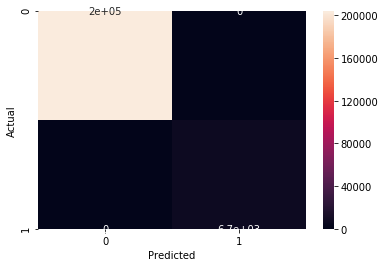

In [17]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn
conf_mat = confusion_matrix(label, predic)
print(conf_mat)
cfs_mat = sn.heatmap(conf_mat, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')